# [Bayesian Thermostat](https://www.frontiersin.org/journals/robotics-and-ai/articles/10.3389/frobt.2019.00020/full) Agent-Environment Simulation

### Using [RxInfer.jl](https://rxinfer.ml/) and [RxEnvironments.jl](https://biaslab.github.io/RxEnvironments.jl/stable/)

In [1]:
using RxInfer
using RxEnvironments
using Distributions
using Plots

## [Environment Specification](https://biaslab.github.io/RxEnvironments.jl/stable/lib/getting_started/#lib-started) with RxEnvironments.jl

In [2]:
"""
Models the distribution of temperature in an interval.

The origin is supposed as the only source of the temperatrue 
and source_temp is the temperature at this source. 
"""
function temperature(position, source_temp)
    return source_temp / (position^2 + 1)
end

temperature

In [8]:
mutable struct BayesianThermostatEnv
    source_temp::Float64
    interval_end_point::Float64
    interval_incr_stepsize::Float64
    temperature_distribution::Function
    interval::Vector{Float64}
    obs_noise_variance::Float64

    # Constructor with default values
    BayesianThermostatEnv(
        source_temp::Float64 = 100.0,
        interval_end_point::Float64 = 16.0,
        interval_incr_stepsize::Float64 = 0.01,
        obs_noise_variance::Float64 = 0.7
    ) = new(
        source_temp,
        interval_end_point, 
        interval_incr_stepsize, 
        temperature, 
        collect(0.0:interval_incr_stepsize:interval_end_point),
        obs_noise_variance
    )
end

In [9]:
# Helper functions
noise(
    env::BayesianThermostatEnv
) = Normal(0.0, env.obs_noise_variance)

exact_temperature(
    env::BayesianThermostatEnv, 
    agent_position::Float64
) = env.temperature_distribution(agent_position, env.source_temp)

noisy_temperature(
    env::BayesianThermostatEnv, 
    agent_position::Float64
) = env.temperature_distribution(agent_position, env.source_temp) + rand(noise(env))

noisy_temperature (generic function with 1 method)

In [10]:
# Create an instance of BayesianThermostatEnv
env = BayesianThermostatEnv(100.0)

BayesianThermostatEnv(100.0, 16.0, 0.01, temperature, [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  15.91, 15.92, 15.93, 15.94, 15.95, 15.96, 15.97, 15.98, 15.99, 16.0], 0.7)

In [11]:
# Generate temperature data
exact_temperatures = [exact_temperature(env, pos) for pos in env.interval];  # Calculate exact temperatures
noisy_temperatures = [noisy_temperature(env, pos) for pos in env.interval];  # Calculate noisy temperatures

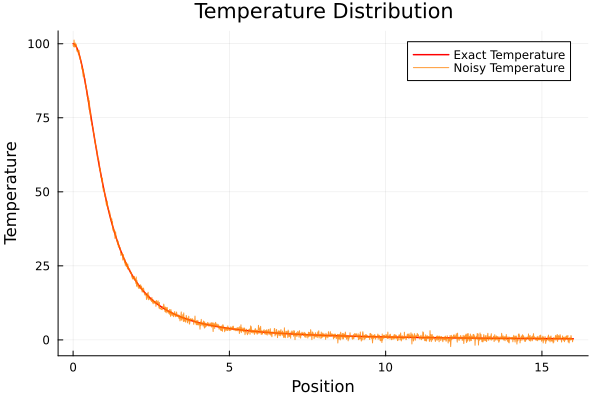

In [12]:
# a custom orange color
dark_orange = RGB(1.0, 0.5, 0.0)

# Plot exact temperatures
plot(
    env.interval, 
    exact_temperatures, 
    linewidth = 1.5,
    color = "red", 
    label = "Exact Temperature", 
    title = "Temperature Distribution", 
    xlabel = "Position", 
    ylabel = "Temperature"
)

# Plot noisy temperatures
plot!(
    env.interval, 
    noisy_temperatures, 
    linewidth = 1.0,
    alpha = 0.8,
    color = dark_orange, 
    label = "Noisy Temperature"
)

## Environment Entity API

In [13]:
# When the environment receives an action from the agent, we shouldn't emit back to the agent
# NOT SURE ABOUT THIS
RxEnvironments.emits(
    subject = env::BayesianThermostatEnv, 
    listener = agent::ThermostatAgent, 
    observtion = observtion::Real
) = false

# In any other case, we should emit (This line is obsolete since this is the default 
# behavior, but we include itfor clarity)
# NOT SURE ABOUT THIS
RxEnvironments.emits(
    subject = env::BayesianThermostatEnv, 
    listener = agent::ThermostatAgent, 
    observation = any
) = true

# The environment sends a noisy temperature observation to the agent.
RxEnvironments.what_to_send(
    recipient = agent::ThermostatAgent,
    emitter = env::BayesianThermostatEnv
) = noisy_temperature(emitter, recipient.position)

# When the environment receives an action from the agent, nothng changes in the 
# environment itself. The temperature distribution is supposed to be static. 
RxEnvironments.receive!(
    recipient = env::BayesianThermostatEnv,
    emitter = agent::ThermostatAgent, 
    action = action::Real
) = nothing
    
# The environment is static across time.
RxEnvironments.update!(
    env::BayesianThermostatEnv, 
    elapsed_time
) = nothing

## [Agent Specification](https://www.frontiersin.org/journals/robotics-and-ai/articles/10.3389/frobt.2019.00020/full) with RxInfer.jl

Almost all of the following text was taken word-for-word from this [paper](https://www.frontiersin.org/journals/robotics-and-ai/articles/10.3389/frobt.2019.00020/full). 

### Generative Model:

We consider an agent with a state-space model (SSM) factorization for its internal model, given by:

\begin{equation}
    p_t(x, s, u) \propto p(s_{t-1})\prod_{k = t}^{t + T}p(x_k | s_k)p(s_k | s_{k - 1}, u_k)p(u_k)p'(x_k)
\end{equation}

where $x$, $s$, and $u$ are sequences of observations, hidden states and controls (respectively). All three of these resepctive sequences have ranges that are implicitly given by the model specification at the right-hand side. Note how the model of this Equation differs slightly from a standard SSM factorization, because it includes additional “target” priors $p'(x_k)$ over desired future outcomes. Also note that the probability distribution for the internal model has a subscript $t$ to indicate that the model is time-varying.

Also note that at time step t, the agent has assumptions about how the environment will evolve over the next $T + 1$ time steps since we can run this model forward and generate observations $x_k$ for $k = t, t + 1, …, t + T$. The horizon T is determined by the information content of the target priors $p'(x_k)$. These target priors are generally set by states of contextual processes, i.e., not by this agent but rather by other agents (or higher level processes) that encode unsurprising future outcomes for this agent. In order to distinguish the predictive model for observations $p(x_k | s_k)$ from the context-based target prior for observations $p'(x_k)$, we label the latter factor with a prime.

We refer to a sequence of future controls $u = (u_t, u_{t + 1}, ..., u_{t + T})$ as a "policy". Through inference, the posterior over policies becomes dependent on the hidden state sequence $s$. Prior to inference however, the model requires the definition of a prior belief over policies that constrains attainable control states. In a more general formulation of the internal model, we would write a prior over policies: $p(u) = p(u_t, u_{t + 1}, ..., u_{t + T})$. Here, for simplicity, we assume:

\begin{equation}
    p(u) = \prod_{k = t}^{t + T}p(u_k)
\end{equation}

### Variational Model:
Next to the internal (generative model) model, we assume that the agent has access to a variational distribution, also known as the recognition distribution:

\begin{equation}
    q_t(x, s, u)
\end{equation}

that encodes the agent's posterior beliefs about all latent states. Because the future is by definition unobserved, the recognition distribution includes the future observation variables as well. The distinction between the agent's prior (“generative”) beliefs $p_t(x, s, u)$ and posterior (“recognition”) beliefs $q_t(x,s, u)$ will be finessed below.

At the start of the simulation (say at $t = 1$), we will set $q_1$ to an uninformative distribution. As time progresses, observations become available and subsequent inference iterations will tune $q_t$ to more informed distributions. Often, but not necessarily so, the recognition distribution is assumed to be fully factorized (this is the mean-field assumption). In the present article we assume a structured factorization for the recognition distribution that is solely induced by the internal model factorization. In general, we may write:

\begin{equation}
    q_t(x, s, u) = q(x, s | u)q(u)
\end{equation}

Since actions onto the environment are real-valued interventions, we will generally enforce a deterministic posterior belief over policies, i.e.,

\begin{equation}
    q(u_t, ..., u_{t + T}) = \prod_{k = t}^{t + T} \delta(u_k - \upsilon_k)
\end{equation}

where $\upsilon_k$ (upsilon) are parameters that are to be determined in the free-energy minimization process. In other words, while the prior belief over policies $p(u)$ may contain uncertainties, we will fix the posterior belief over policies $q(u)$ on a single concrete sequence.

As time progresses, at each time step, the agent interacts with its environment through exchanging actions and observations, followed by processing the observations. Technically, everything that the agents does can be described as updates to its internal and recognition models.

### Agent-Environment Assumptions:

The environmental process consists of two things: the closed interval: $[0, E_p]$ and the function:

\begin{equation}
    T(z) = \frac{T_0}{z^2 + 1}
\end{equation}

Which specifies a temperature distribution on the interval. Here, $E_p > 0$ is the end point of the interval and $z$ is the agent's position in the environment's interval. $T_0$ is the temperature at the source/origin. We will use $T_0 = 100.0$. 

The environmental process is steered by actions $a_t$ that reflect the velocity of the agent. The output of the environmental process is the observed temperature by the agent. We assume that the agent observes a noisy temperature, leading to the following environmental process equations:

\begin{equation}
    z_t = z_{t - 1} + a_t
\end{equation}

Where $z_t$ is the agent's position in the environmental interval: $z_t \in [0, E_p]$. We also assume that the agent observes a noisy temperature:

\begin{equation}
    y_t \sim \mathcal{N}(T(z_t), \vartheta)
\end{equation}

Hence $y_t$ is the agent's noisy observation of the temperature at position $z_t$ in the environemntal interval. We use the following observation noise variance: $\vartheta = 10^{-2}$. 

### Model Specification

#### Initial Position:
The agent shall start at position $z_0 = 2.0$ in the environmental interval. 

#### Goal Prior Model:
The agent's goal prior over observations $p'(x_k)$ encodes a belief about a preferred temperature observation. Let the agent's prefered temperature observation be denoted as $x_*$. We set agent's prefered temperature observation to be $4.0$. hence:

\begin{equation}
    p'(x_k) = \mathcal{N}(x_k | x_*, 10^{-2})
\end{equation}

#### System Dynamics Model:
Furthermore, we endow the agent with an accurate model of system dynamics:

\begin{equation}
    p(s_k | s_{k - 1}, u_k) = \mathcal{N}(s_k | s_{k - 1} + u_k, 10^{-2})
\end{equation}

#### Observation Model:
However, in order to challenge the agent, we hamper the observation model. Instead of the actual temperature profile $y_t \sim \mathcal{N}(T(z_t), \vartheta)$, we use:

\begin{equation}
    p(x_k | s_k) = \mathcal{N}(x_k | - s_k, 10^{-2})
\end{equation}

which simply specifies that the observed temperature decreases with position. This is true of course, but this is a significant "coarse-graining" of the full situation - given by the above specified temperature function: $T(z)$.  

#### Control Model and Initial State:
We specify a prior for controls:

\begin{equation}
    p(u_k) = \mathcal{N}(u_k | 0, 10^{-2})
\end{equation}

and a vague prior for the initial state:

\begin{equation}
    p(s_0) = \mathcal{N}(s_0 | 0, 10^{12})
\end{equation}

This fully defines the agent's internal model: $p_t(x, s, u)$.

In [14]:
# The agent is specified via its generative model. 
struct ThermostatAgent 
    position::Float64 # the agent's position in the interval
    infered_action::Float64 # the action that the agent has inferred 

    # Constructor with default values
    ThermostatAgent(
        position::Float64 = 2.0, # initial position
        infered_action::Float64 = 0.0 # initial action is 0.0 (for no effect)
    ) = new(
        position, 
        infered_action
    )
end

In [9]:
# Modeled after the existing Mountain Car @model: 
# https://reactivebayes.github.io/RxInfer.jl/stable/examples/advanced_examples/Active%20Inference%20Mountain%20car/
# The analytic form of the generative model is the same, so it seems like it should be a 
# reasonably analogous @model. 

# # Arguments
# - m_x: Mean of the goal prior observation.
# - V_x: Variance of the goal prior observation.
# - m_s_t: Mean of the system state dynamics.
# - V_s_t: Variance of the system state dynamics.
# - m_u: Mean of the control prior.
# - V_u: Variance of the control prior.
# - T: Planning horizon, default is 3.

# # Returns
# - The instantiated Bayesian thermostat model, in addition to posteriors over s, x and u.
@model function bayesian_thermostat_model_1(
        m_x, V_x,
        m_s_t, V_s_t,
        m_u, V_u,
        T # plan over a future time horizon of 3 steps
    )
    
    # Initial action prior:
    u[1] ~ Normal(mean = m_u[1], variance = V_u[1])

    # Initial state prior:
    s_t ~ Normal(mean = m_s_t, variance = V_s_t)
    s_k = s_t
    s[1] = s_k
    local s
    
    # Initial observation prior:
    x[1] ~ Normal(mean = m_x[1], variance = 1e-2)
    
    # Observation-goal prior:
    x_goal[1] ~ Normal(mean = m_x[1], variance = V_x[1])
    
    # State dynamics:
    for k in 2:T
        u[k] ~ MvNormal(mean = m_u[k], variance = V_u[k])
        s[k] ~ Normal(mean = s[k - 1] + u[k], variance = 1e-2)
        x[x] ~ Normal(mean = -s[k], variance = 1e-2)
        x_goal[k] ~ Normal(mean = m_x[k], variance = V_x[k]) # goal prior
        s_k = s[k] # proceed to the next state in the time horizon
    end

    return (s, x, u)
end

In [15]:
# Modeled after the existing Drone navigation @model: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/blob/main/drone/drone_simulation.ipynb

# # Arguments
# - m_x: Mean of the goal prior observation.
# - V_x: Variance of the goal prior observation.
# - m_s_t: Mean of the system state dynamics.
# - V_s_t: Variance of the system state dynamics.
# - m_u: Mean of the control prior.
# - V_u: Variance of the control prior.
# - T: Planning horizon, default is 3.

# # Returns
# - The instantiated Bayesian thermostat model, in addition to posteriors over s, x and u.
@model function bayesian_thermostat_model_2(
        agent,
        observation_t,
        T # plan over a future time horizon of 3 steps
    )
    
    # TAKE THE OBSERVATION AS AN ARGUMENT?
    
    # Initial action prior:
    u[1] ~ Normal(mean = 0.0, variance = 1e-2)

    # Initial state prior:
    s_t ~ Normal(mean = agent.position, variance = 1e-2) # initial state prior is centered on the current position
    s_k = s_t
    s[1] = s_k
    
    # Initial observation prior:
    x[1] ~ Normal(mean = observation_t, variance = 1e-2)
    
    # Observation-goal prior:
    x_goal[1] ~ Normal(mean = 4.0, variance = 1e-2)
    
    # State dynamics:
    for k in 2:T
        u[k] ~ MvNormal(mean = 0.0, variance = 1e-2)
        s[k] ~ Normal(mean = s[k - 1] + u[k], variance = 1e-2)
        x[x] ~ Normal(mean = -s[k], variance = 1e-2)
        x_goal[k] ~ Normal(mean = 4.0, variance = 1e-2) # goal prior
        s_k = s[k] # proceed to the next state in the time horizon
    end

    return (s, x, u)
end

## Agent Entity API

In [16]:
# When the agent receives an observation from the environment, we shouldn't emit back to the environment
# NOT SURE ABOUT THIS
RxEnvironments.emits(
    subject = agent::ThermostatAgent, # env::BayesianThermostatEnv, 
    listener = env::BayesianThermostatEnv, # agent::ThermostatAgent, 
    observtion = observtion::Real
) = false

# In any other case, we should emit (This line is obsolete since this is the default 
# behavior, but we include itfor clarity)
# NOT SURE ABOUT THIS
RxEnvironments.emits(
    subject =  agent::ThermostatAgent, # env::BayesianThermostatEnv, 
    listener = env::BayesianThermostatEnv, # agent::ThermostatAgent, 
    observation = any
) = true

# The agent sends an action to move itself
RxEnvironments.what_to_send(
    recipient = agent::ThermostatAgent,
    emitter = agent::ThermostatAgent,
) = recipient.position + recipient.infered_action 

# When the agent receives an observation from the environment, the agent engages in active inference
RxEnvironments.receive!(
    recipient = agent::ThermostatAgent, # env::BayesianThermostatEnv,
    emitter = env::BayesianThermostatEnv, # agent::ThermostatAgent, 
    observation = observation::Real
) = recipient.infered_action = infer_action(recipient, observation, 3) # ??????????????????????
    
# The agent position is only updated if it explicitely performs this action
RxEnvironments.update!(
    agent::ThermostatAgent,  # env::BayesianThermostatEnv, 
    elapsed_time
) = nothing

## Sensor-Motor Loop Implementation

In [30]:
function infer_action(
        agent::ThermostatAgent,
        observation_t::Float64, 
        T::Int64
    )
    
    data = Dict(
        :agent => agent,
        :observation_t => observation_t
    )

    model = bayesian_thermostat_model_2(
        T = T
    )
    
    # ISSUE HERE:
    result = infer(
        model = model, 
        data = data
    )
    
    return result.posteriors[:u]
end

infer_action (generic function with 1 method)

In [31]:
agent = ThermostatAgent()

ThermostatAgent(2.0, 0.0)

In [32]:
println(agent.position)
println(agent.infered_action)

2.0
0.0


In [33]:
"""
Iterates the sensor-motor loop, otherwise known 
as a "single agent - single environent" subscription.  
"""
function run_smloop(
        environment::BayesianThermostatEnv, 
        agent::ThermostatAgent, 
        total_time::Int64
    )
    
    observation_t = agent.position + rand(Normal(0.0, 1e-2))
    
    for i in 1:total_time
        
        action = infer_action(
            agent,
            observation_t,
            3 # agent's planning time horizon
        )
        
        RxEnvironments.send!(
            environment, 
            agent, 
            action
        )
        
    end
end

run_smloop

In [34]:
run_smloop(
    env,
    agent,
    100
)

LoadError: MethodError: no method matching iterate(::ThermostatAgent)

[0mClosest candidates are:
[0m  iterate([91m::Combinatorics.IntegerPartitions[39m)
[0m[90m   @[39m [32mCombinatorics[39m [90m~/.julia/packages/Combinatorics/Udg6X/src/[39m[90m[4mpartitions.jl:20[24m[39m
[0m  iterate([91m::Combinatorics.IntegerPartitions[39m, [91m::Any[39m)
[0m[90m   @[39m [32mCombinatorics[39m [90m~/.julia/packages/Combinatorics/Udg6X/src/[39m[90m[4mpartitions.jl:20[24m[39m
[0m  iterate([91m::StatsBase.CoefTable[39m)
[0m[90m   @[39m [33mStatsBase[39m [90m~/.julia/packages/StatsBase/ebrT3/src/[39m[90m[4mstatmodels.jl:42[24m[39m
[0m  ...
